In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------
# Load trained ElasticNet model from file
# ----------------------------------------
model = joblib.load("./trained_models/elasticnet_model.pkl")
print("ElasticNet model loaded.")

# ----------------------------------------
# Load dataset to get feature names
# ----------------------------------------
df = pd.read_csv("./dataset/cleaned_train.csv")
X = df.drop(columns=["SalePrice"])
y = np.log1p(df["SalePrice"])
feature_names = X.columns


ElasticNet model loaded.


In [33]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

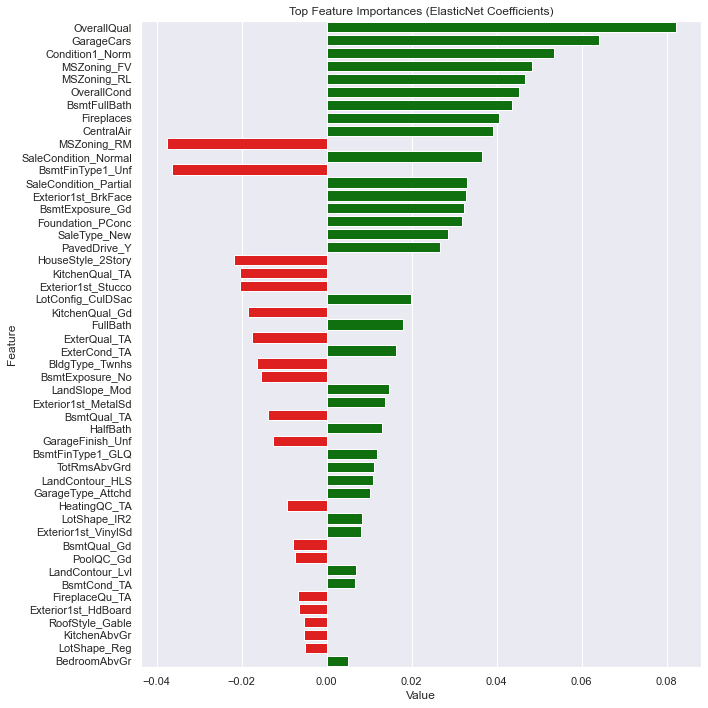

In [34]:
def plot_importance(model, features, num=50, save=False):
    # Check if model has coefficients
    if not hasattr(model, "coef_"):
        raise AttributeError("The model does not have 'coef_' attribute.")

    # Create DataFrame of feature importance
    feature_imp = pd.DataFrame({
        'Value': model.coef_,
        'Feature': features.columns
    })
    feature_imp["AbsValue"] = feature_imp["Value"].abs()
    feature_imp = feature_imp.sort_values(by="AbsValue", ascending=False).head(50)

    # Plot
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp,
                palette=["green" if v > 0 else "red" for v in feature_imp["Value"]])
    plt.title('Top Feature Importances (ElasticNet Coefficients)')
    plt.tight_layout()
    plt.show()

# Call the function
plot_importance(model, X)

## LOFO Importance

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train full model
baseline_model = ElasticNet(alpha=model.alpha, l1_ratio=model.l1_ratio)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_val)

# Compute baseline error (MSE)
baseline_error = mean_squared_error(y_val, y_pred_base)
print(f"Baseline MSE: {baseline_error:.4f}")

# LOFO importance computation
lofo_scores = []

for feature in feature_names:
    # Remove feature j
    X_train_lofo = X_train.drop(columns=[feature])
    X_val_lofo = X_val.drop(columns=[feature])

    model_lofo = ElasticNet(alpha=model.alpha, l1_ratio=model.l1_ratio)
    model_lofo.fit(X_train_lofo, y_train)
    y_pred_lofo = model_lofo.predict(X_val_lofo)

    # Compute error
    lofo_error = mean_squared_error(y_val, y_pred_lofo)

    # LOFO as difference
    importance_diff = lofo_error - baseline_error

    # Option 2 (optional): LOFO as ratio
    # importance_ratio = lofo_error / baseline_error

    lofo_scores.append({
        "Feature": feature,
        "LOFO_Importance": importance_diff
    })
    print(f"LOFO {feature}: ΔMSE = {importance_diff:.5f}")

Baseline MSE: 0.0218
LOFO MSSubClass: ΔMSE = -0.00039
LOFO LotFrontage: ΔMSE = -0.00048
LOFO LotArea: ΔMSE = 0.00002
LOFO Alley: ΔMSE = 0.00000
LOFO OverallQual: ΔMSE = 0.00344
LOFO OverallCond: ΔMSE = 0.00213
LOFO YearBuilt: ΔMSE = 0.00025
LOFO YearRemodAdd: ΔMSE = -0.00027
LOFO MasVnrArea: ΔMSE = 0.00004
LOFO BsmtFinSF1: ΔMSE = 0.00002
LOFO BsmtUnfSF: ΔMSE = 0.00001
LOFO TotalBsmtSF: ΔMSE = 0.00011
LOFO CentralAir: ΔMSE = 0.00012
LOFO 1stFlrSF: ΔMSE = -0.00002
LOFO 2ndFlrSF: ΔMSE = -0.00002
LOFO GrLivArea: ΔMSE = -0.00002
LOFO BsmtFullBath: ΔMSE = -0.00018
LOFO BsmtHalfBath: ΔMSE = -0.00000
LOFO FullBath: ΔMSE = 0.00012
LOFO HalfBath: ΔMSE = -0.00001
LOFO BedroomAbvGr: ΔMSE = -0.00003
LOFO KitchenAbvGr: ΔMSE = 0.00000
LOFO TotRmsAbvGrd: ΔMSE = 0.00005
LOFO Fireplaces: ΔMSE = -0.00017
LOFO GarageYrBlt: ΔMSE = -0.00012
LOFO GarageCars: ΔMSE = 0.00033
LOFO GarageArea: ΔMSE = -0.00016
LOFO WoodDeckSF: ΔMSE = 0.00006
LOFO OpenPorchSF: ΔMSE = 0.00000
LOFO EnclosedPorch: ΔMSE = 0.00009
LOFO

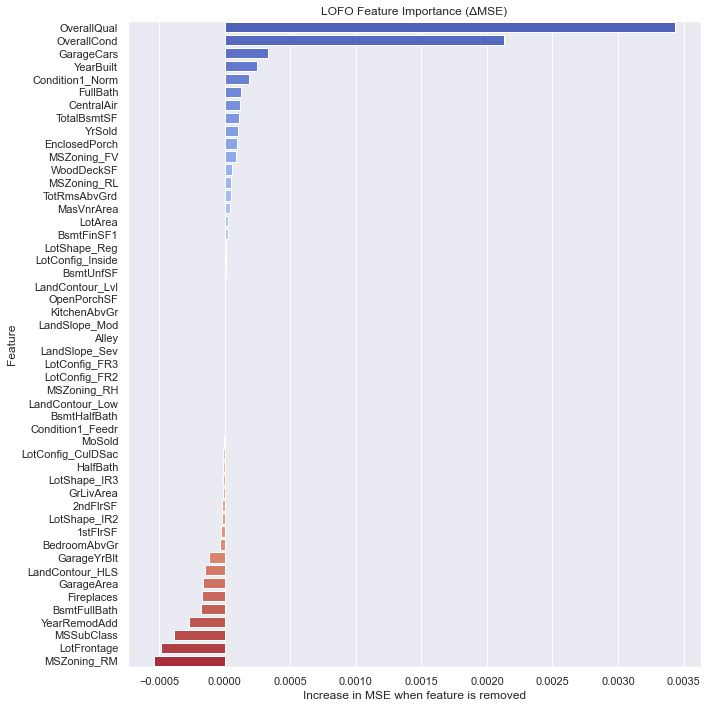

In [37]:
# Create DataFrame
lofo_df = pd.DataFrame(lofo_scores[:50]).sort_values(by="LOFO_Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 10))
sns.barplot(data=lofo_df, y="Feature", x="LOFO_Importance", palette="coolwarm")
plt.title("LOFO Feature Importance (ΔMSE)")
plt.xlabel("Increase in MSE when feature is removed")
plt.tight_layout()
plt.show()


In [47]:
lofo_df

,Feature,LOFO_Importance
4,OverallQual,3.436077e-03
5,OverallCond,2.131881e-03
25,GarageCars,3.302591e-04
6,YearBuilt,2.463739e-04
49,Condition1_Norm,1.849988e-04
18,FullBath,1.232779e-04
12,CentralAir,1.169968e-04
11,TotalBsmtSF,1.130905e-04
31,YrSold,1.048608e-04
29,EnclosedPorch,9.466675e-05


## Select top features for PDP/ICE

In [48]:
from sklearn.inspection import plot_partial_dependence, PartialDependenceDisplay
# --- Select Top 6 Important Features (by absolute coefficient) ---
top_features = lofo_df.sort_values(by="LOFO_Importance", ascending=False).head(6)["Feature"].tolist()

top_features

['OverallQual',
 'OverallCond',
 'GarageCars',
 'YearBuilt',
 'Condition1_Norm',
 'FullBath']

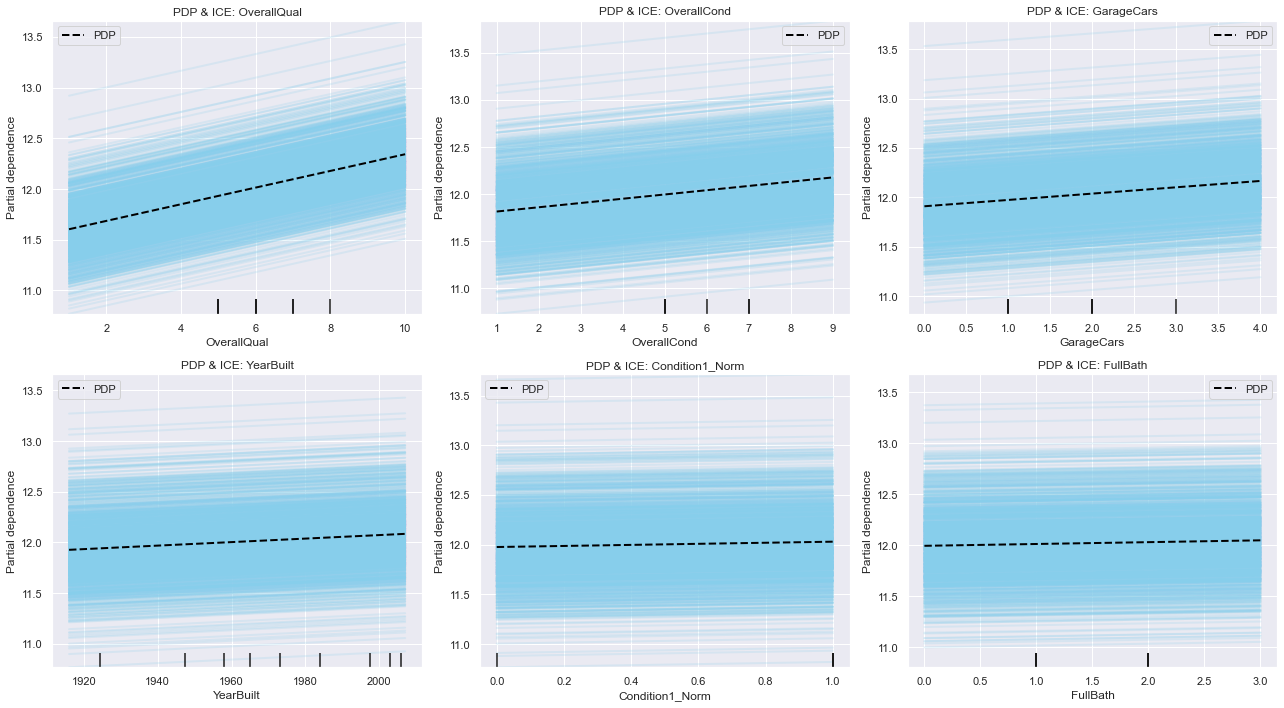

In [49]:
# --- PDP & ICE Plots: 3 columns × 2 rows ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=[feature],
        kind="both",
        ax=axes[i],
        line_kw={"label": "PDP", "color": "black", "linewidth": 2},
        ice_lines_kw={"alpha": 0.2, "color": "skyblue"},
    )
    axes[i].set_title(f"PDP & ICE: {feature}")
    axes[i].set_ylabel("Predicted SalePrice")

# Remove any unused subplot (in case < 6 features)
for j in range(len(top_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

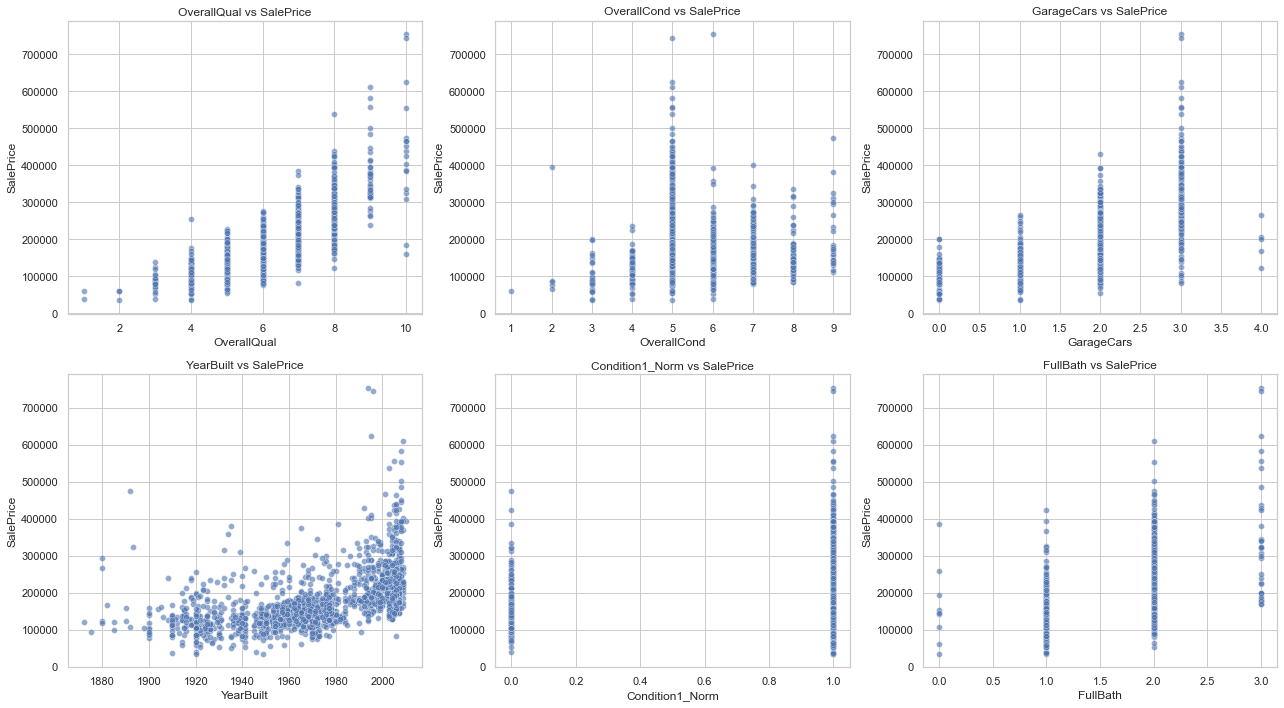

In [53]:
# List of selected features
features = ['OverallQual', 'OverallCond', 'GarageCars', 'YearBuilt', 'Condition1_Norm', 'FullBath']

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 10))

# Create scatter plots in 2 rows × 3 columns
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=df, x=feature, y="SalePrice", alpha=0.6)
    plt.title(f"{feature} vs SalePrice")
    plt.xlabel(feature)
    plt.ylabel("SalePrice")

plt.tight_layout()
plt.show()

## Surrogate Models

In [76]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

R² score of Surrogate vs Complex model: 0.7877


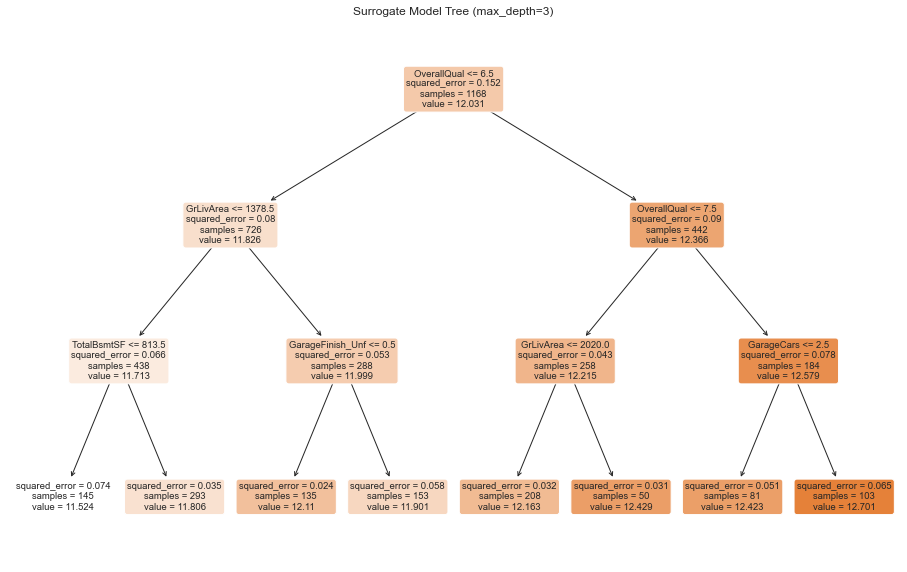

In [79]:
# Train surrogate model to mimic predictions
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train full model
baseline_model = ElasticNet(alpha=model.alpha, l1_ratio=model.l1_ratio)
baseline_model.fit(X_train, y_train)
y_pred_complex = baseline_model.predict(X_val)

surrogate = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate.fit(X_train, y_train)
y_pred_surrogate = surrogate.predict(X_val)

# Evaluate how well surrogate mimics the original model
r2 = r2_score(y_pred_complex, y_pred_surrogate)
print(f"R² score of Surrogate vs Complex model: {r2:.4f}")

# Plot the surrogate tree
plt.figure(figsize=(16, 10))
plot_tree(surrogate, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Surrogate Model Tree (max_depth=3)")
plt.show()

In [2]:
import shap
import lime
import lime.lime_tabular

In [ ]:
# Choose an instance to explain
i = 50
instance = X.iloc[[i]]

# -------------------------
# SHAP using KernelExplainer (model-agnostic)
# -------------------------
explainer_shap = shap.KernelExplainer(model.predict, X.sample(100))  # background set
shap_values = explainer_shap.shap_values(instance)

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Plot SHAP waterfall
shap.initjs()
shap.force_plot(explainer_shap.expected_value, shap_values, instance)

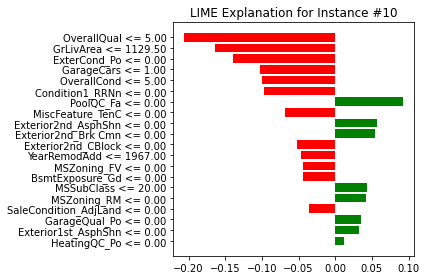

<Figure size 1440x720 with 0 Axes>

In [8]:
# -------------------------
# LIME Explanation
# -------------------------
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    mode="regression"
)

exp = explainer_lime.explain_instance(
    data_row=instance.values[0],
    predict_fn=model.predict,
    num_features=20
)

# Show LIME result
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance #{i}")
plt.tight_layout()
plt.figure(figsize=(20, 10))
plt.show()